In [ ]:
!git clone https://github.com/TheAlphaJas/Liver-Tumor-Seg-Implements.git

Cloning into 'Liver-Tumor-Seg-Implements'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 26 (delta 3), reused 9 (delta 0), pack-reused 11 (from 1)
Receiving objects: 100% (26/26), 64.60 MiB | 18.24 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (9/9), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The ZIP file path on your Drive (make sure this is correct!)
ZIP_FILE_PATH = "/content/drive/MyDrive/archive.zip"

# The local destination directory on the Colab SSD
LOCAL_DATA_DIR = "/content/data/"

# Create the local data directory
!mkdir -p "$LOCAL_DATA_DIR"

In [ ]:
print(f"Starting FAST local extraction to: {LOCAL_DATA_DIR}")

# --- THE -q FLAG HAS BEEN REMOVED FOR VISIBILITY ---
# The unzip utility runs much faster when writing to the local SSD!
!unzip "$ZIP_FILE_PATH" -d "$LOCAL_DATA_DIR"
# ----------------------------------------------------

print("\nFAST Extraction complete.")

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/dataset_6/dataset_6/volume-93_81.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_82.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_83.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_84.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_85.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_86.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_87.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_88.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_89.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_9.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_90.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_91.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_92.png  
  inflating: /content/data/dataset_6/dataset_6/volume-93_93.png  
  inflating: /content/data

In [ ]:
print("Installing required dependencies...")

# Install specific versions of TensorFlow, Keras, and helper libraries
!pip install tensorflow keras numpy opencv-python imageio

print("\nDependencies installed.")

Installing required dependencies...

Dependencies installed.


In [ ]:
#General Imports
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras

In [ ]:
import os
import random
import re
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
# Base path where your files are located
BASE_PATH = "/content/data/dataset_6/dataset_6/"

# 1. FIND AND PAIR FILES
print("Scanning files...")
all_files = os.listdir(BASE_PATH)

# Regex patterns to match your specific filenames
# Volume: volume-130_620.png -> captures (130, 620)
# Mask: segmentation-130_livermask_620.png -> captures (130, 620)
vol_pattern = re.compile(r'volume-(\d+)_(\d+)\.png')
seg_pattern = re.compile(r'segmentation-(\d+)_livermask_(\d+)\.png')

mask_lookup = {}
# First, map all masks: (PatientID, SliceID) -> FilePath
for f in all_files:
    match = seg_pattern.search(f)
    if match:
        pid, sid = match.group(1), match.group(2)
        mask_lookup[(pid, sid)] = os.path.join(BASE_PATH, f)

# Next, find volumes that have matching masks
patient_map = {} # Stores pairs by patient_id
pair_count = 0

for f in all_files:
    match = vol_pattern.search(f)
    if match:
        pid, sid = match.group(1), match.group(2)

        # Check if corresponding mask exists
        if (pid, sid) in mask_lookup:
            vol_path = os.path.join(BASE_PATH, f)
            mask_path = mask_lookup[(pid, sid)]

            if pid not in patient_map:
                patient_map[pid] = []
            patient_map[pid].append((vol_path, mask_path))
            pair_count += 1

print(f"Found {pair_count} valid image-mask pairs across {len(patient_map)} patients.")

# 2. SPLIT BY PATIENT (Prevents Data Leakage)
patient_ids = list(patient_map.keys())
random.seed(42)
random.shuffle(patient_ids)

# 80% Train, 10% Val, 10% Test
n = len(patient_ids)
train_ids = patient_ids[:int(0.8*n)]
val_ids   = patient_ids[int(0.8*n):int(0.9*n)]
test_ids  = patient_ids[int(0.9*n):]

# Helper to flatten the lists
def get_data_lists(p_ids):
    x, y = [], []
    for pid in p_ids:
        for xp, yp in patient_map[pid]:
            x.append(xp)
            y.append(yp)
    return x, y

X_train, Y_train = get_data_lists(train_ids)
X_val, Y_val     = get_data_lists(val_ids)
X_test, Y_test   = get_data_lists(test_ids)

print(f"Train Slices: {len(X_train)}")
print(f"Val Slices:   {len(X_val)}")
print(f"Test Slices:  {len(X_test)}")

# 3. CREATE TENSORFLOW DATASETS
def load_image_mask(x_path, y_path):
    # Load Image
    img = tf.io.read_file(x_path)
    img = tf.image.decode_png(img, channels=1) # Grayscale
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (256, 256))

    # Load Mask
    mask = tf.io.read_file(y_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    mask = tf.cast(mask, tf.float32)
    mask = mask / 255.0
    # Binarize (Tumor vs Background)
    mask = tf.where(mask > 0, 1.0, 0.0)

    return img, mask

def create_dataset(x, y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # FILTER: Remove empty masks (slices with no tumor)
    # This matches the original paper's logic and stabilizes loss
    ds = ds.filter(lambda img, mask: tf.reduce_max(mask) > 0)

    if training:
        ds = ds.shuffle(1000)

    ds = ds.batch(16)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

print("Creating Datasets...")
train_ds = create_dataset(X_train, Y_train, training=True)
val_ds   = create_dataset(X_val, Y_val, training=False)
test_ds  = create_dataset(X_test, Y_test, training=False)

print("✅ Data Pipeline Ready.")

Scanning files...
Found 58638 valid image-mask pairs across 131 patients.
Train Slices: 46586
Val Slices:   5737
Test Slices:  6315
Creating Datasets...
✅ Data Pipeline Ready.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

# --- 1. METRICS & LOSS FUNCTIONS ---
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    smooth = 1.0
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# --- 2. U-NET ARCHITECTURE ---
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    # Block 1
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    # Block 2
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Block 3
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Block 4
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoder
    # Block 6
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # Block 7
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Block 8
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # Block 9
    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# --- 3. COMPILE AND TRAIN ---
model = unet_model()

# We use 1e-4 as a standard starting rate.
# The ReduceLROnPlateau callback will lower it to 1e-5 (paper value) if loss stops improving.
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy', dice_coef])

print("Model Compiled.")
model.summary()

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model_best.keras', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
]

print("Starting Training...")
# Note: Since your dataset is huge (46k images), one epoch will take time.
# We set epochs=30, but EarlyStopping will likely stop it sooner if it converges.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Model Compiled.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 256, 256,  │          0 │ conv2d_38[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │      9,248 │ dropout_18[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128, 128,  │          0 │ conv2d_40[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │     36,928 │ dropout_19[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 64, 64,    │          0 │ conv2d_42[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │    147,584 │ dropout_20[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 32, 32,    │          0 │ conv2d_44[0][0]   │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │    590,080 │ dropout_21[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_45[0][0] 

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

Starting Training...
Epoch 1/30
    960/Unknown 337s 324ms/step - accuracy: 0.8166 - dice_coef: 0.5121 - loss: 0.4879
Epoch 1: val_loss improved from inf to 0.34068, saving model to model_best.keras
960/960 ━━━━━━━━━━━━━━━━━━━━ 363s 352ms/step - accuracy: 0.8167 - dice_coef: 0.5123 - loss: 0.4877 - val_accuracy: 0.9311 - val_dice_coef: 0.6593 - val_loss: 0.3407 - learning_rate: 1.0000e-04
Epoch 2/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9812 - dice_coef: 0.8645 - loss: 0.1355
Epoch 2: val_loss improved from 0.34068 to 0.20467, saving model to model_best.keras
960/960 ━━━━━━━━━━━━━━━━━━━━ 335s 338ms/step - accuracy: 0.9812 - dice_coef: 0.8645 - loss: 0.1355 - val_accuracy: 0.9642 - val_dice_coef: 0.7955 - val_loss: 0.2047 - learning_rate: 1.0000e-04
Epoch 3/30
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9886 - dice_coef: 0.9169 - loss: 0.0831
Epoch 3: val_loss improved from 0.20467 to 0.16010, saving model to model_best.keras
960/960 ━━━━━━━━━━━━━━━━━━━━ 

Loading best model from model_best.keras...
✅ Model loaded successfully!

--- Final Test Set Evaluation ---
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 262ms/step - accuracy: 0.9934 - dice_coef: 0.9385 - loss: 0.0615
Test Dice Score (Accuracy): 0.9377
Test Loss: 0.0624

--- Visualizing Results ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


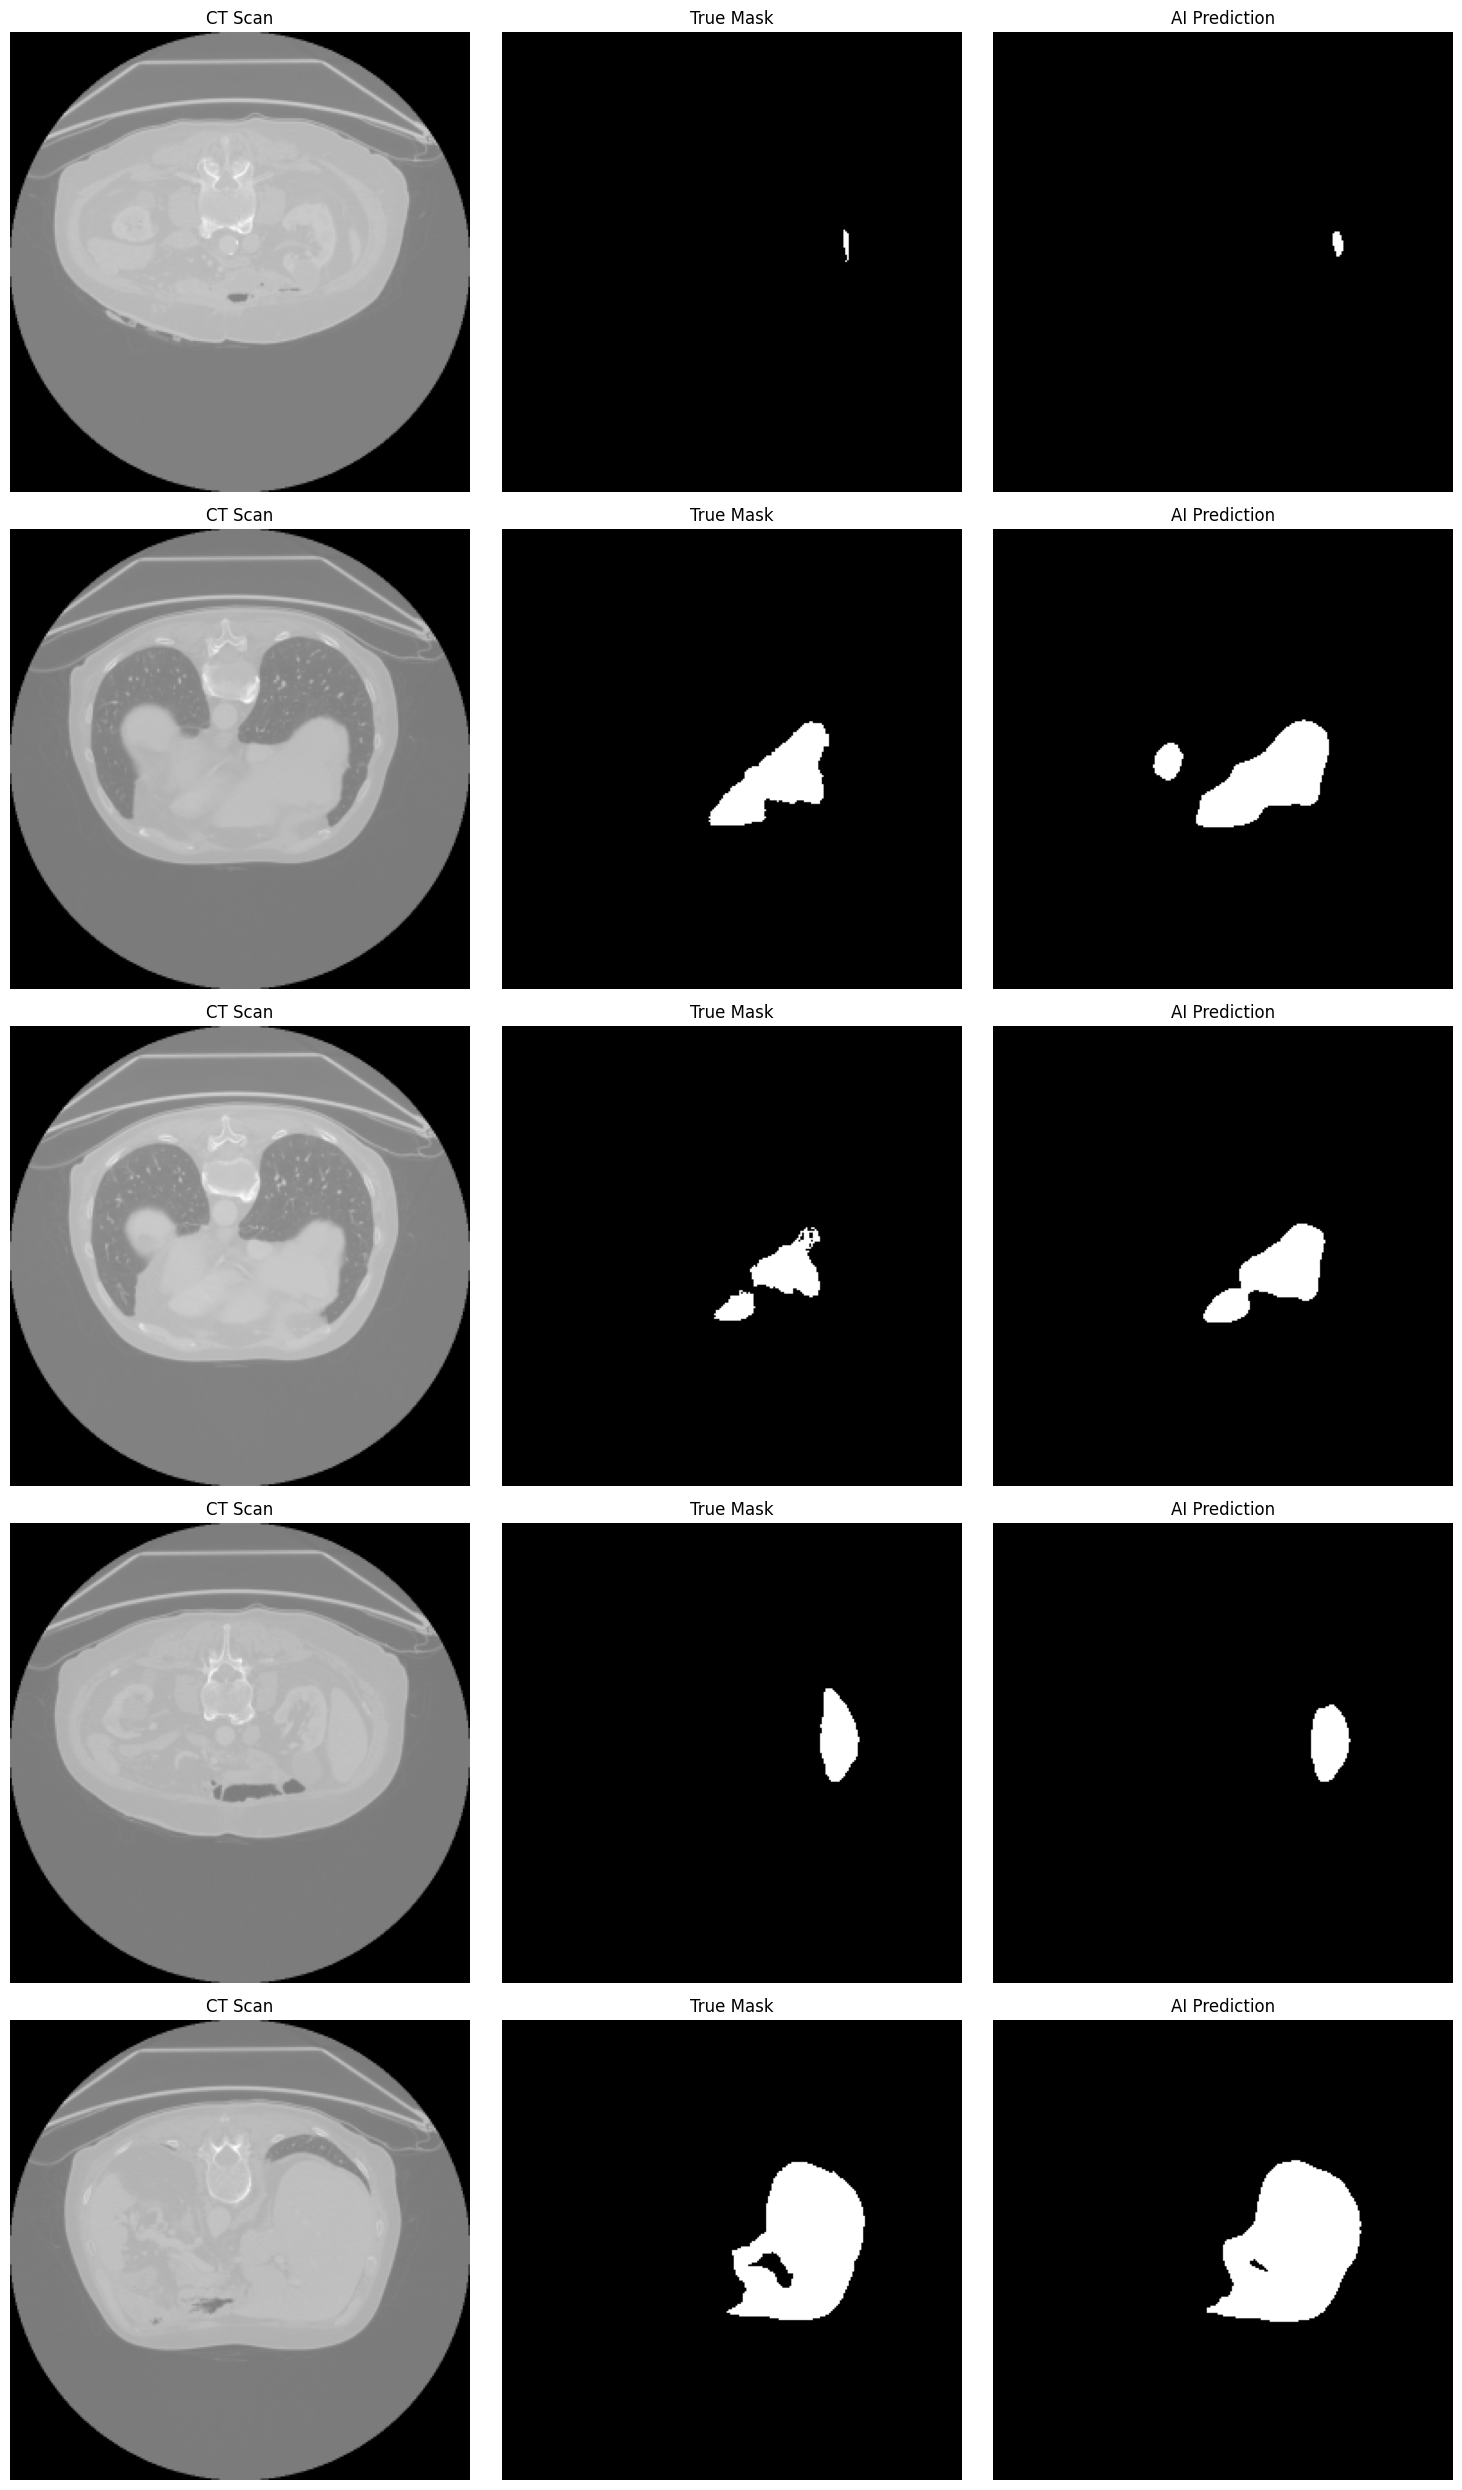

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the Best Model
# Check where your file is. If it's in the current folder:
model_path = 'model_best.keras'

# If you moved it to Drive, change the path to: '/content/drive/MyDrive/...'

print(f"Loading best model from {model_path}...")
custom_objects = {'dice_loss': dice_loss, 'dice_coef': dice_coef}

try:
    best_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Make sure the file 'model_best.keras' is in the file list on the left.")

# 2. Evaluate on the TEST Set (The final exam)
print("\n--- Final Test Set Evaluation ---")
test_loss, test_acc, test_dice = best_model.evaluate(test_ds)
print(f"Test Dice Score (Accuracy): {test_dice:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# 3. Visualize Predictions
def show_predictions(model, dataset, num=5):
    plt.figure(figsize=(15, 5*num))

    # Take 1 batch from the test set
    for images, masks in dataset.take(1):
        preds = model.predict(images)

        for i in range(num):
            # Original CT
            plt.subplot(num, 3, i*3 + 1)
            plt.imshow(images[i, :, :, 0], cmap='gray')
            plt.title("CT Scan")
            plt.axis('off')

            # True Mask (Doctor)
            plt.subplot(num, 3, i*3 + 2)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title(f"True Mask")
            plt.axis('off')

            # AI Prediction
            plt.subplot(num, 3, i*3 + 3)
            plt.imshow(preds[i, :, :, 0] > 0.5, cmap='gray') # Threshold at 0.5
            plt.title(f"AI Prediction")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\n--- Visualizing Results ---")
show_predictions(best_model, test_ds)

In [ ]:
# import os

# # Define the paths
# temp_path = 'model_best.keras'                  # Temporary Colab storage
# drive_path = '/content/drive/MyDrive/model_best.keras' # Safe Google Drive storage

# print("--- SAFETY CHECK ---")

# # 1. Check Temporary Storage
# if os.path.exists(temp_path):
#     print(f"⚠️ FOUND in Temp Storage: {os.path.getsize(temp_path)/1e6:.2f} MB")
#     print("   (This file will disappear when you close Colab!)")
# else:
#     print("❌ NOT found in Temp Storage.")

# # 2. Check Google Drive
# if os.path.exists(drive_path):
#     print(f"✅ FOUND in Google Drive: {os.path.getsize(drive_path)/1e6:.2f} MB")
#     print("   (This file is safe forever.)")
# else:
#     print("❌ NOT found in Google Drive.")

--- SAFETY CHECK ---
⚠️ FOUND in Temp Storage: 93.29 MB
   (This file will disappear when you close Colab!)
❌ NOT found in Google Drive.


In [ ]:
# import shutil

# source = 'model_best.keras'
# destination = '/content/drive/MyDrive/liver_tumor_model_final.keras'

# try:
#     shutil.copy(source, destination)
#     print("✅ Success! File copied to Google Drive.")
# except Exception as e:
#     print(f"Error: {e}")

✅ Success! File copied to Google Drive.


In [1]:
# Create the app.py file
app_code = """
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

# --- 1. Define Custom Metrics (REQUIRED to load the model) ---
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    smooth = 1.0
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# --- 2. Load the Model ---
# This assumes the model file is in the same folder as this script
model = tf.keras.models.load_model('model_best.keras', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

# --- 3. Prediction Function ---
def predict_segmentation(image):
    # Resize to 256x256
    img_resized = cv2.resize(image, (256, 256))

    # Grayscale conversion
    if len(img_resized.shape) == 3:
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_resized

    # Normalize and Reshape (Model expects: Batch, Height, Width, Channel)
    img_input = img_gray.astype("float32") / 255.0
    img_input = np.expand_dims(img_input, axis=-1)
    img_input = np.expand_dims(img_input, axis=0)

    # Predict
    pred_mask = model.predict(img_input)
    output_mask = pred_mask[0, :, :, 0]

    # Threshold (0.5) to make it binary
    binary_mask = (output_mask > 0.5).astype(np.uint8) * 255
    return binary_mask

# --- 4. Launch Interface ---
interface = gr.Interface(
    fn=predict_segmentation,
    inputs=gr.Image(label="Upload CT Slice"),
    outputs=gr.Image(label="AI Prediction"),
    title="Liver Tumor Segmentation",
    description="Upload a CT scan slice to see the segmented liver area."
)

interface.launch()
"""

with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py created successfully!")

✅ app.py created successfully!


In [2]:
reqs = """
tensorflow
gradio
opencv-python-headless
numpy
"""

with open("requirements.txt", "w") as f:
    f.write(reqs)

print("✅ requirements.txt created successfully!")

✅ requirements.txt created successfully!
